# ひろしまQuest2020 Training

In [1]:
# 自分のマイドライブにマウントする(Google Colab使用時)

#from google.colab import drive
#drive.mount('/content/drive/')

In [2]:
#cd "/content/drive/MyDrive"

In [3]:
import numpy as np
import os
import pandas as pd

In [4]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import pathlib
import shutil

## ImageDataGenerator用のデータセットを作成

In [6]:
dataset_path = pathlib.Path('.')
#dataset_path = pathlib.Path('/content/drive/MyDrive')#Colab使用時
dataset_path

PosixPath('.')

In [7]:
images_folder = ['0優良', '1良', '2加工品', '3規格外']

train_folder_path = './train_images_gen'
val_folder_path = './val_images_gen'

# フォルダ作成
for img_f in images_folder:
    os.makedirs(train_folder_path + '/' + img_f, exist_ok=True)
    os.makedirs(val_folder_path + '/' + img_f, exist_ok=True)
    
print("Train folder: ", os.listdir(train_folder_path))
print("Validation folder: ", os.listdir(val_folder_path))

Train folder:  ['0優良', '.DS_Store', '3規格外', '1良', '2加工品']
Validation folder:  ['0優良', '.DS_Store', '3規格外', '1良', '2加工品']


In [8]:
train_df = pd.read_csv(dataset_path/'train_images.csv')
#train_df

In [9]:
n_picture = []
for l in range(len(images_folder)):    
    n_picture.append(len(train_df[train_df['class_num']==l]))
print("Pictures: ", n_picture)
print("Total: ", sum(n_picture))

Pictures:  [400, 255, 235, 212]
Total:  1102


<BarContainer object of 4 artists>

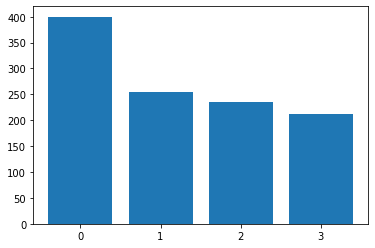

In [10]:
images_label_list = ['0', '1', '2', '3']
plt.bar(images_label_list, n_picture)

In [11]:
#全ファイルコピー(シャッフルできていない)
#1回実行したらコメントアウトでOK（ドライブにファイルを作るのが目的のため）

# train_test_split
total_size = sum(n_picture)
ratio = 0.7
total_train = int(total_size*ratio)
total_val = int(total_size-total_train)

for l in range(len(images_folder)):
    i = 0                 
    # validation data
    while i < int(n_picture[l]*ratio):
            file_name = train_df[train_df['class_num']==l].loc[train_df[train_df['class_num']==l].index[i]]['id']
            in_path = dataset_path/'train_images'/file_name
            out_path = val_folder_path + '/' + images_folder[l] + '/' + file_name
            shutil.copyfile(in_path, out_path)
            _, _, files = next(os.walk(val_folder_path + '/' + images_folder[l]))
            file_count = len(files)
            i += 1
    # train data       
    while i < n_picture[l]:
            file_name = train_df[train_df['class_num']==l].loc[train_df[train_df['class_num']==l].index[i]]['id']
            in_path = dataset_path/'train_images'/file_name
            out_path = train_folder_path + '/' + images_folder[l] + '/' + file_name
            shutil.copyfile(in_path, out_path)
            _, _, files = next(os.walk(train_folder_path + '/' + images_folder[l]))
            file_count = len(files)
            i += 1

## データ拡張


In [12]:
train_image_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=360,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        zoom_range=0.5,
                                        shear_range=0.1,
                                        fill_mode = 'nearest'
                                        )

In [13]:
validation_image_generator = ImageDataGenerator(rescale=1./255) # 検証データのジェネレータ

In [14]:
BATCH_SIZE = 8
epochs = 100

IMG_HEIGHT = 320
IMG_WIDTH = 320

In [15]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_folder_path,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes = images_folder)

Found 332 images belonging to 4 classes.


In [16]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                          directory=val_folder_path,
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                          class_mode='categorical',
                                                          classes = images_folder)

Found 770 images belonging to 4 classes.


In [17]:
print("Train generator's label:\n", train_data_gen.class_indices)
print("Validation generator's label:\n", val_data_gen.class_indices)

Train generator's label:
 {'0優良': 0, '1良': 1, '2加工品': 2, '3規格外': 3}
Validation generator's label:
 {'0優良': 0, '1良': 1, '2加工品': 2, '3規格外': 3}


## Training

In [18]:
import tensorflow as tf
import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import models, layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adamax
from keras.losses import CategoricalCrossentropy

## Model
reference  
https://www.kaggle.com/bununtadiresmenmor/starter-keras-efficientnet



In [19]:
def create_model():
    model = models.Sequential()
    
    model.add(DenseNet121(include_top = False,
                            weights = 'imagenet',
                            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    
    model.add(layers.Dropout(0.5))#0.5, 0.8
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(1024, activation = 'relu'))
    model.add(layers.Dropout(0.2))#0.5, 0.8

    model.add(layers.Dense(len(images_folder), activation = "softmax"))
    
    return model 

In [20]:
model = create_model()

### Callbacks

In [21]:
checkpoint = ModelCheckpoint(
                            "./checkpoint_best",
                            monitor = "val_loss",
                            verbose = 1,
                            save_best_only = True,
                            save_weights_only = False,
                            mode = "min")

In [22]:
early_stop= EarlyStopping(
                            monitor = "val_loss",
                            min_delta=0.001,
                            patience=7,#10
                            verbose=1,
                            mode="min",
                            restore_best_weights=False)

In [23]:
reduce_lr = ReduceLROnPlateau(
                            monitor="val_loss",
                            factor=0.1,
                            patience=2,
                            verbose=1,
                            mode="min",
                            min_delta=0.0001)

In [24]:
model.compile(
            optimizer = Adamax(),
            loss = CategoricalCrossentropy(label_smoothing=0.3,reduction="auto",name="categorical_crossentropy"),
            metrics = ["accuracy"])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 10, 10, 1024)      7037504   
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 1024)      0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4100      
Total params: 8,091,204
Trainable params: 8,007,556
Non-trainable params: 83,648
_________________________________________

### 学習

In [26]:
history = model.fit_generator(
                                train_data_gen,
                                steps_per_epoch=None,
                                epochs=epochs,
                                validation_data=val_data_gen,
                                validation_steps=None,
                                callbacks = [checkpoint ,early_stop,reduce_lr]
                            )

/Users/ishiitomoaki/.pyenv/versions/anaconda3-2020.07/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
42/42 [==============================] - 809s 19s/step - loss: 1.7807 - accuracy: 0.5020 - val_loss: 4.6340 - val_accuracy: 0.4026

Epoch 00001: val_loss improved from inf to 4.63402, saving model to ./checkpoint_best
INFO:tensorflow:Assets written to: ./checkpoint_best/assets
Epoch 2/100
42/42 [==============================] - 747s 18s/step - loss: 1.0803 - accuracy: 0.7579 - val_loss: 1.2586 - val_accuracy: 0.5792

Epoch 00002: val_loss improved from 4.63402 to 1.25863, saving model to ./checkpoint_best
INFO:tensorflow:Assets written to: ./checkpoint_best/assets
Epoch 3/100
42/42 [==============================] - 630s 15s/step - loss: 1.0435 - accuracy: 0.7840 - val_loss: 1.4369 - val_accuracy: 0.5584

Epoch 00003: val_loss did not improve from 1.25863
Epoch 4/100
42/42 [==============================] - 652s 16s/step - loss: 0.9871 - accuracy: 0.8454 - val_loss: 1.0968 - val_accuracy: 0.6857

Epoch 00004: val_loss improved from 1.25863 to 1.09675, saving model to ./che

In [27]:
# モデルを保存
model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model/assets


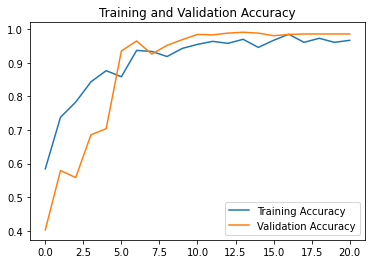

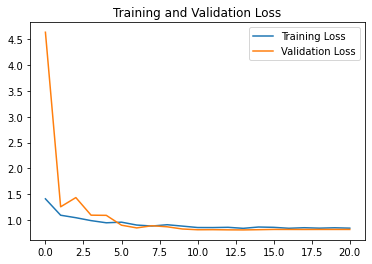

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


predictに続く